In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn import datasets
import random
import matplotlib.pyplot as plt

class GeneticAlgorithm:
    def __init__(self, chromosome, data_points):
        self.chromosome = chromosome
        self.data_points = data_points
        self.classes = list(set(datasets.load_iris().target))
        self.fitness_score = self._calculate_fitness()

    def _calculate_fitness(self):
        labels = np.array(list((self.chromosome.values())))
        unique_labels = np.unique(labels)

        if len(unique_labels) < 2:
            return -1

        fitness_score = silhouette_score(self.data_points, labels)
        return fitness_score

    def mutation(self):
        self._change_labels_to_nearest_center()
        return self.chromosome

    def generate_child(self, parent):
        new_generation = {}
        for index in range(len(self.chromosome)):
            probability = random.random()

            if probability < 0.50:
                new_generation[index] = self.chromosome[index]
            elif probability < 0.99:
                new_generation[index] = parent.chromosome[index]
            else:
                new_generation[index] = random.choice(self.classes)

        return GeneticAlgorithm(new_generation, self.data_points)

    def _change_labels_to_nearest_center(self):
        sample_cluster_labels = random.choice(self.classes)
        labels_nearest_cluster = self._find_labels_nearest_cluster(sample_cluster_labels)

        number_of_sample_cluster_labels = list(self.chromosome.values()).count(sample_cluster_labels)

        counter = 1
        for index in range(len(self.chromosome)):
            if self.chromosome[index] == sample_cluster_labels:
                self.chromosome[index] = labels_nearest_cluster
                counter += 1
            if counter == number_of_sample_cluster_labels // 3:
                break

    def _find_labels_nearest_cluster(self, sample_cluster_labels):
        sample_cluster = {}
        _sample_cluster = []
        for index in range(len(self.chromosome)):
            if self.chromosome[index] == sample_cluster_labels:
                _sample_cluster.append(self.data_points[index])
        sample_cluster[sample_cluster_labels] = _sample_cluster

        clusters = {}
        for _label in self.classes:
            cluster = []
            if sample_cluster_labels != _label:
                for index, label in self.chromosome.items():
                    if label == _label:
                        cluster.append(self.data_points[index])
                clusters[_label] = cluster

        center_sample = self._find_center_cluster(sample_cluster[sample_cluster_labels])

        centers = [self._find_center_cluster(cluster_data) for cluster_data in clusters.values()]
        distances = [self._calculate_distance(center, center_sample) for center in centers]
        index_nearest_center = np.argsort(distances)[0]

        labels_nearest_cluster = list(clusters)[index_nearest_center]
        return labels_nearest_cluster

    def _find_center_cluster(self, cluster):
        data = list(map(np.array, cluster))
        data = np.array(data)
        center = np.mean(data, axis=0)
        return center

    def _calculate_distance(self, point1, point2):
        point1 = np.array(point1)
        point2 = np.array(point2)
        distance = np.sqrt(np.sum((point1 - point2) ** 2))
        return distance

In [32]:
class GeneticCluster:
    def __init__(self, data_points, labels, population_size=50, threshold=0.9, repeat=100, mutate=True):
        self.data_points = data_points
        self.classes = list(np.unique(labels))
        self.population_size = population_size
        self.threshold = threshold
        self.repeat = repeat
        self.population = []
        self.mutate = mutate
        self.fitness_scores = []

    def fit(self):
        for _ in range(self.population_size):
            chromosome = self._create_random_chromosome()
            self.population.append(GeneticAlgorithm(chromosome, self.data_points))
        self.counter = 1

        while True:
            if self.counter == self.repeat:
                break
            self.population = sorted(self.population, key=lambda chromosome: chromosome.fitness_score, reverse=True)

            if self.threshold <= self.population[0].fitness_score <= 1:
                break

            new_generation = self._generate_next_generation()

            self.population = new_generation

            if self.mutate:
                self._apply_mutation()

            self.fitness_scores.append(self.population[0].fitness_score)
            self.counter += 1
            self.show()

    def _create_random_chromosome(self):
        chromosome = {index: random.choice(self.classes) for index in range(self.data_points.shape[0])}
        return chromosome

    def _generate_next_generation(self):
        size_best_people = int((10 * self.population_size) / 100)
        new_generation = self.population[:size_best_people]

        for _ in range(int((90 * self.population_size) / 100)):
            parent1 = random.choice(self.population[:50])
            parent2 = random.choice(self.population[:50])
            child = parent1.generate_child(parent2)
            new_generation.append(child)

        return new_generation

    def _apply_mutation(self, mutation_probability=0.9):
        for index in range(self.population_size):
            random_number = random.random()
            if random_number > mutation_probability:
                self.population[index] = GeneticAlgorithm(self.population[index].mutation(), self.data_points)

    def show(self):
        print()
        print(f"Generation num.: {self.counter} \tFitness Value: {self.population[0].fitness_score}")

    def show_plot(self):
        plt.plot(self.fitness_scores)

In [33]:
# Test the GeneticCluster class
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
data_points = np.array(iris_df[["petal length (cm)", "petal width (cm)"]])
labels = iris.target


Generation num.: 2 	Fitness Value: -0.025361852204586567

Generation num.: 3 	Fitness Value: 0.004075668947517993

Generation num.: 4 	Fitness Value: 0.004075668947517993

Generation num.: 5 	Fitness Value: 0.006408067090435499

Generation num.: 6 	Fitness Value: 0.006408067090435499

Generation num.: 7 	Fitness Value: 0.0700183669829391

Generation num.: 8 	Fitness Value: 0.0700183669829391

Generation num.: 9 	Fitness Value: -0.007469155760772999

Generation num.: 10 	Fitness Value: 0.13599483717803817

Generation num.: 11 	Fitness Value: 0.1824836707985956

Generation num.: 12 	Fitness Value: 0.22737888695895103

Generation num.: 13 	Fitness Value: 0.1992465163942073

Generation num.: 14 	Fitness Value: 0.3141836249386222

Generation num.: 15 	Fitness Value: 0.36096849634510375

Generation num.: 16 	Fitness Value: 0.3879790235634145

Generation num.: 17 	Fitness Value: 0.43469593026400655

Generation num.: 18 	Fitness Value: 0.38346038097332413

Generation num.: 19 	Fitness Value: 

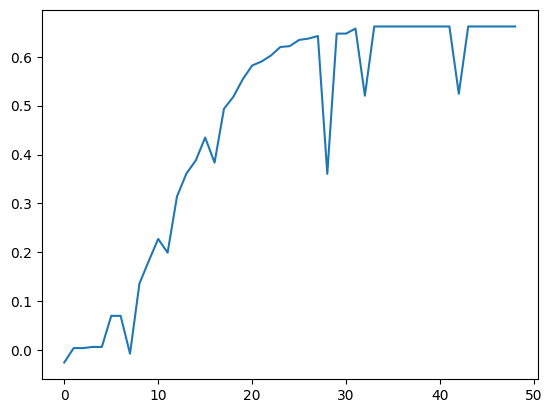

In [41]:
# Instantiate and fit the model with mutation
model = GeneticCluster(data_points=data_points, labels=labels, population_size=500, threshold=0.8, repeat=50, mutate=True)
model.fit()
model.show_plot()


Generation num.: 2 	Fitness Value: -0.02020671509012588

Generation num.: 3 	Fitness Value: -0.02020671509012588

Generation num.: 4 	Fitness Value: -0.02020671509012588

Generation num.: 5 	Fitness Value: -0.02020671509012588

Generation num.: 6 	Fitness Value: -0.02001109240650461

Generation num.: 7 	Fitness Value: -0.019277362057058274

Generation num.: 8 	Fitness Value: -0.014460130416934384

Generation num.: 9 	Fitness Value: -0.0016828303162588927

Generation num.: 10 	Fitness Value: 0.005751198955663528

Generation num.: 11 	Fitness Value: 0.02280474460660033

Generation num.: 12 	Fitness Value: 0.02280474460660033

Generation num.: 13 	Fitness Value: 0.03819447478510733

Generation num.: 14 	Fitness Value: 0.047725417208757094

Generation num.: 15 	Fitness Value: 0.06007087934832334

Generation num.: 16 	Fitness Value: 0.0829525571028607

Generation num.: 17 	Fitness Value: 0.10346580284429249

Generation num.: 18 	Fitness Value: 0.11599583365197418

Generation num.: 19 	Fitn

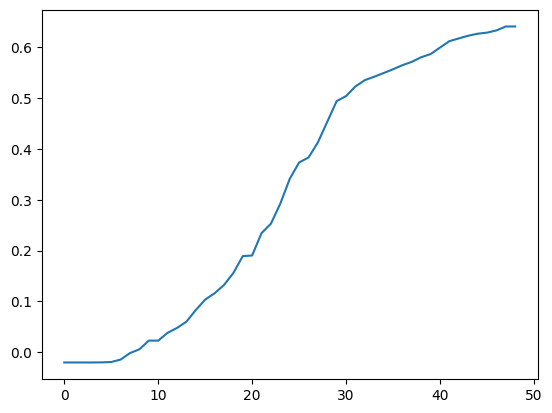

In [42]:
# Instantiate and fit the model
GeneticModel = GeneticCluster(data_points=data_points, labels=labels, population_size=500, threshold=0.8, repeat=50, mutate=False)
GeneticModel.fit()
GeneticModel.show_plot()

In [43]:
def evaluate_kmeans(data_points, num_clusters=2):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(data_points)
    labels = kmeans.labels_
    score = silhouette_score(data_points, labels)
    print(f"Silhouette Score for KMeans with {num_clusters} clusters: {score}")


# Evaluate KMeans with different numbers of clusters independently
evaluate_kmeans(data_points, num_clusters=2)
evaluate_kmeans(data_points, num_clusters=3)

Silhouette Score for KMeans with 2 clusters: 0.7653904101258123
Silhouette Score for KMeans with 3 clusters: 0.6604800083974887
